In [342]:
from datetime import datetime
import pandas as pd
import os
import dateutil.parser as date_parser
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.arima import arima_string
import itertools

## Load timeseries ticker data
### There are 3 tickers analysis is based on:
- S&P 500
- VIX - Volatility index
- US Treasury bonds

The analysis period is from 2000 to 2024

In [293]:
snp_path = os.path.join(os.getcwd(), 'assets', 's&p500_max.csv')
vix_path = os.path.join(os.getcwd(), 'assets', 'vix_max.csv')
us_treasury_bonds_path = os.path.join(os.getcwd(), 'assets', 'us_bonds_max.csv')

snp_data = pd.read_csv(snp_path, index_col='date', parse_dates=True)
vix_data = pd.read_csv(vix_path, index_col='date', parse_dates=True)
bonds_data = pd.read_csv(us_treasury_bonds_path, index_col='date', parse_dates=True)

start_date = '2000-01-01'
end_date = '2024-01-01'

snp_data = snp_data.loc[start_date:end_date]
vix_data = vix_data.loc[start_date:end_date]
bonds_data = bonds_data.loc[start_date:end_date]

# expected business days frequency. Input dataset might have some missing
frequency = 'B'
full_b_days = pd.date_range(start=snp_data.index.min(), end=snp_data.index.max(), freq=frequency)

# common_index = pd.DatetimeIndex(common_index, freq='B')

snp_data = snp_data.reindex(full_b_days)
vix_data = vix_data.reindex(full_b_days)
bonds_data = bonds_data.reindex(full_b_days)
snp_data['close'] = snp_data['close'].interpolate(method='linear')
vix_data['close'] = vix_data['close'].interpolate(method='linear')
bonds_data['close'] = bonds_data['close'].interpolate(method='linear')

missing_days = full_b_days.difference(snp_data.index)

assert len(missing_days) == 0

### S&P 500

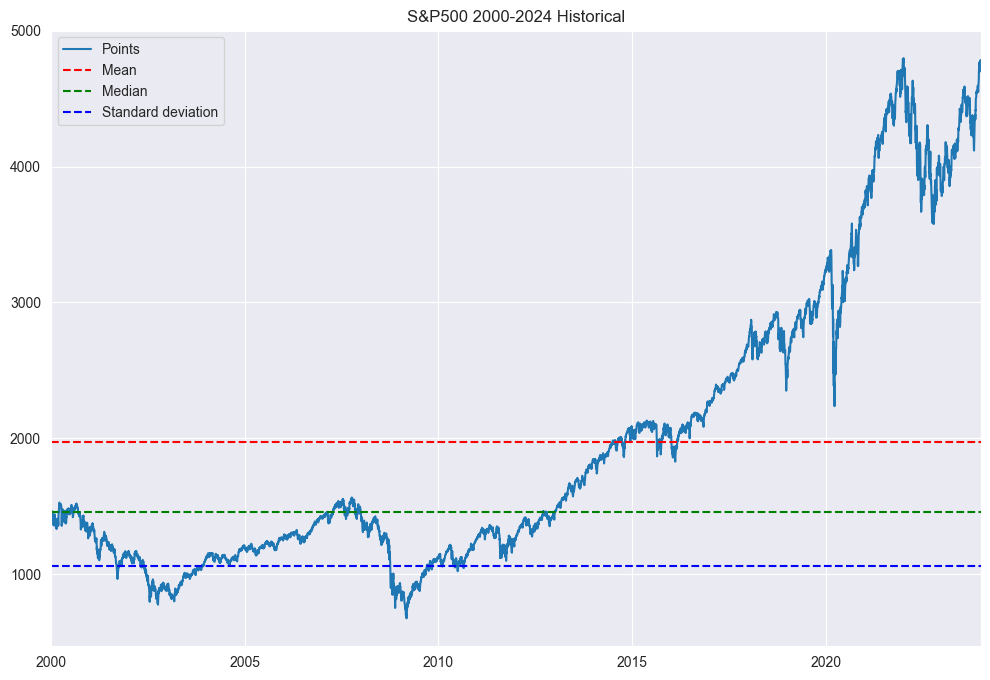

In [294]:
snp_plot = snp_data.plot(title='S&P500 2000-2024 Historical', y='close', label='Points', figsize=(12, 8))
snp_mean = snp_data['close'].mean()
snp_median = snp_data['close'].median()
snp_std = snp_data['close'].std()

snp_plot.axhline(y=snp_mean, label='Mean', color='r', linestyle='dashed')
snp_plot.axhline(y=snp_median, label='Median', color='g', linestyle='dashed')
snp_plot.axhline(y=snp_std, label='Standard deviation', color='b', linestyle='dashed')

snp_plot.legend()

### VIX

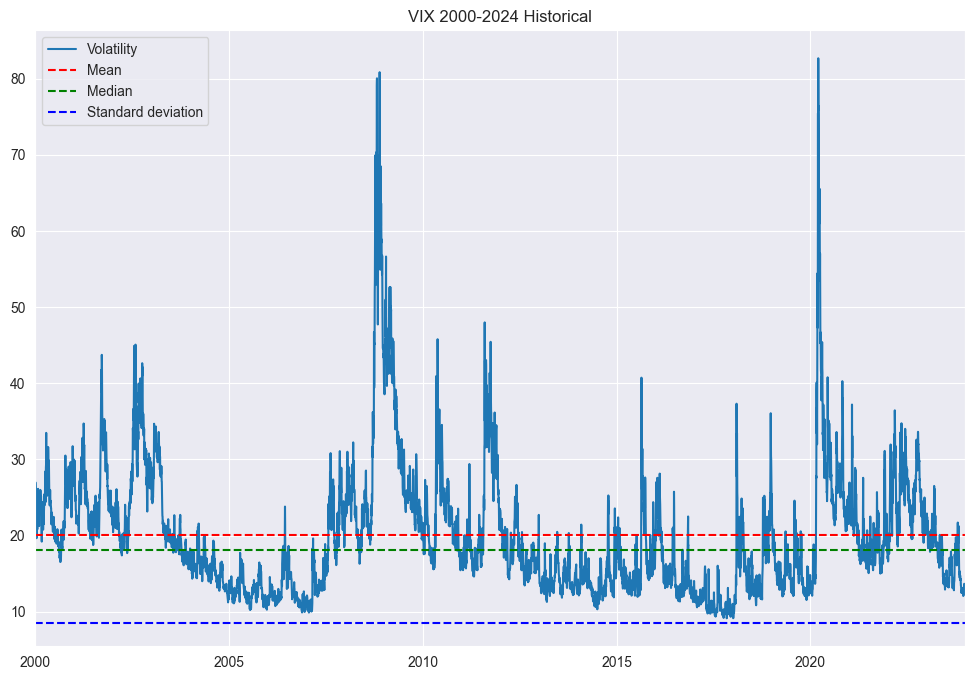

In [296]:
vix_plot = vix_data.plot(title='VIX 2000-2024 Historical', y='close', figsize=(12, 8), label='Volatility')

vix_mean = vix_data['close'].mean()
vix_median = vix_data['close'].median()
vix_std = vix_data['close'].std()

vix_plot.axhline(y=vix_mean, label='Mean', color='r', linestyle='dashed')
vix_plot.axhline(y=vix_median, label='Median', color='g', linestyle='dashed')
vix_plot.axhline(y=vix_std, label='Standard deviation', color='b', linestyle='dashed')

vix_plot.legend()

### US Bonds

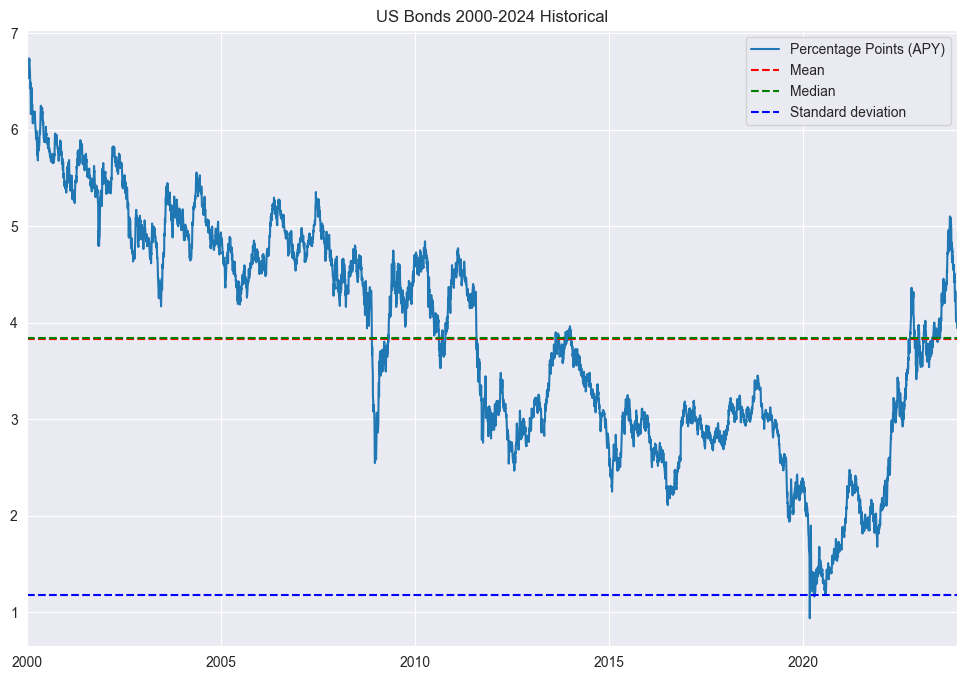

In [297]:
bonds_plot = bonds_data.plot(title='US Bonds 2000-2024 Historical', y='close',
                             label='Percentage Points (APY)', figsize=(12, 8))

bonds_mean = bonds_data['close'].mean()
bonds_median = bonds_data['close'].median()
bonds_std = bonds_data['close'].std()

bonds_plot.axhline(y=bonds_mean, label='Mean', color='r', linestyle='dashed')
bonds_plot.axhline(y=bonds_median, label='Median', color='g', linestyle='dashed')
bonds_plot.axhline(y=bonds_std, label='Standard deviation', color='b', linestyle='dashed')

bonds_plot.legend()

### Heatmap correlation matrix between S&P, VIX and US Bonds

Text(0.5, 1.0, 'Correlation matrix')

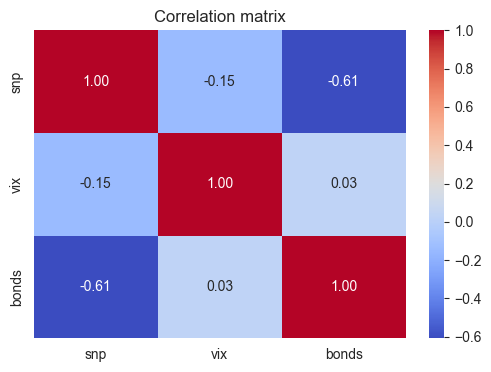

In [298]:
matrix_df = pd.DataFrame({
    'snp': snp_data['close'],
    'vix': vix_data['close'],
    'bonds': bonds_data['close']
})

corr_matrix_df = matrix_df.corr()

fig, ax = plt.subplots(figsize=(6, 4))

heatmap = sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
heatmap.set_title('Correlation matrix')

### Simple correlation between between S&P, VIX and US Bonds

Text(0.5, 1.0, 'Simple correlation')

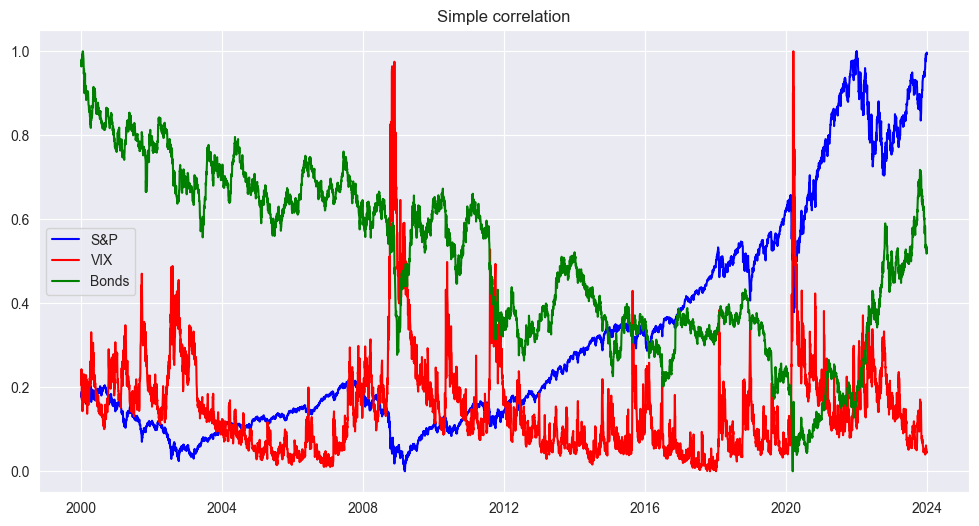

In [350]:
fig, ax = plt.subplots(figsize=(12, 6))

snp_norm = (snp_data['close'] - snp_data['close'].min()) / (snp_data['close'].max() - snp_data['close'].min())
vix_norm = (vix_data['close'] - vix_data['close'].min()) / (vix_data['close'].max() - vix_data['close'].min())
bonds_norm = (bonds_data['close'] - bonds_data['close'].min()) / (bonds_data['close'].max() - bonds_data['close'].min())

ax.plot(snp_norm.index, snp_norm, color='b', label='S&P')
ax.plot(vix_norm.index, vix_norm, color='r', label='VIX')
ax.plot(bonds_norm.index, bonds_norm, color='g', label='Bonds')
ax.legend()
ax.set_title('Simple correlation')

### Data model synthesis with numpy Gaussian Distribution
#### Characteristics used:
- Mean
- Median
- Std

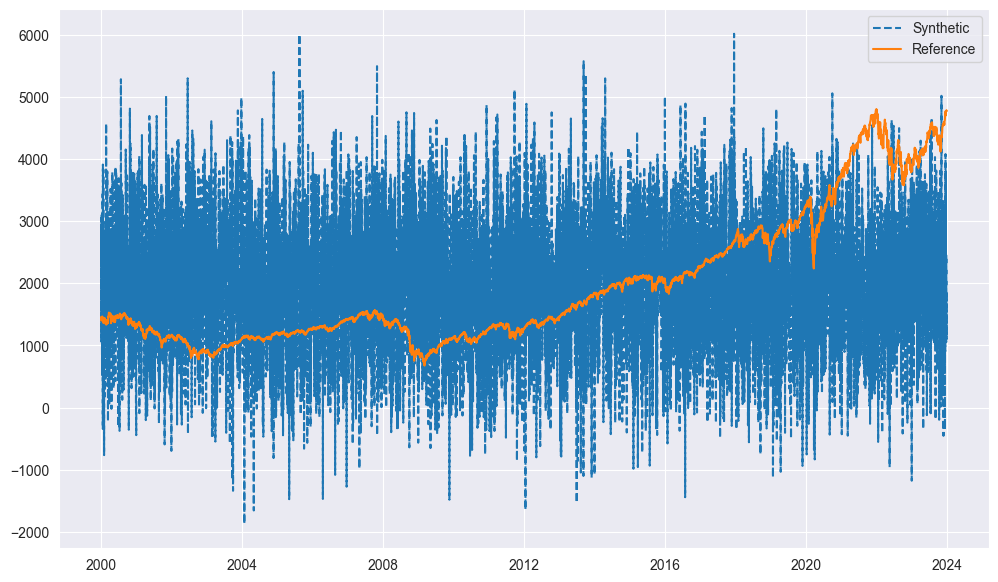

In [300]:
snp_synthetic = np.random.normal(loc=snp_mean, scale=snp_std, size=len(snp_data['close']))

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(snp_data.index, snp_synthetic, linestyle='--', label='Synthetic')
ax.plot(snp_data.index, snp_data['close'], label='Reference')
ax.legend()

### S&P 500 Decomposition

Text(0.5, 1.0, 'Residuals')

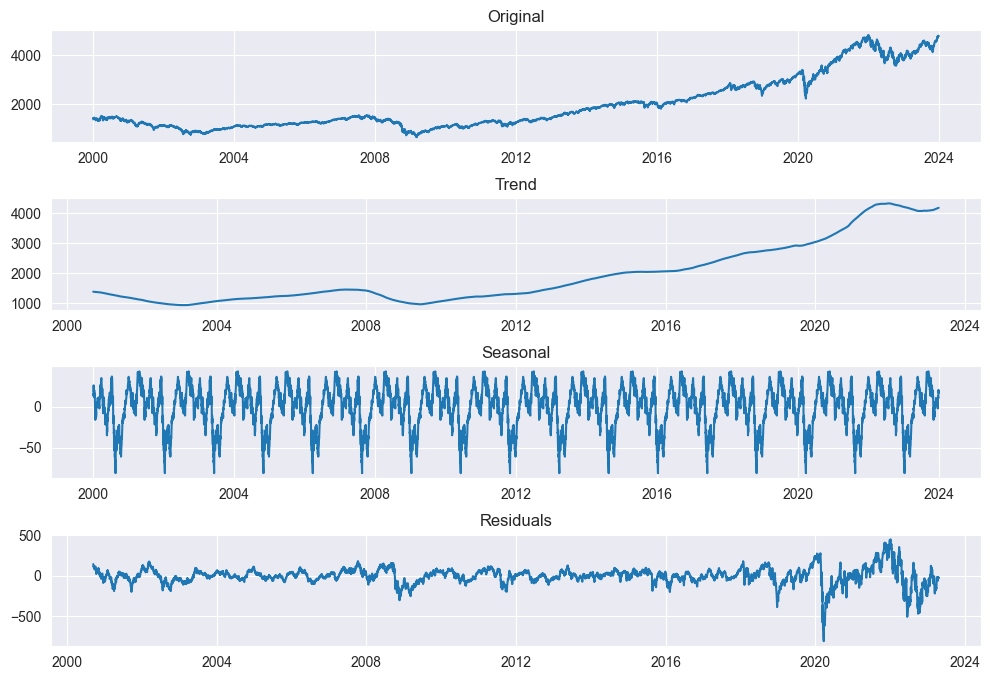

In [301]:
result = seasonal_decompose(snp_data['close'], model='additive', period=365)
fig, axs = plt.subplots(nrows=4, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
start_date_comp = start_date
end_date_comp = end_date

axs[0].plot(snp_data['close'][start_date_comp:end_date_comp], label='Original')
axs[0].set_title('Original')
axs[1].plot(result.trend[start_date_comp:end_date_comp], label='Trend')
axs[1].set_title('Trend')
axs[2].plot(result.seasonal[start_date_comp:end_date_comp], label='Seasonal')
axs[2].set_title('Seasonal')
axs[3].plot(result.resid[start_date_comp:end_date_comp], label='Residuals')
axs[3].set_title('Residuals')

### Stationary test (Dicker-Fuller)
- Null Hypothesis - if true (a = 1), the series is stationary
- Alternate Hypothesis - if ture, the series is non-stationary

Test Statistic:  1.4781644817965207 {'1%': -3.4314005857922973, '5%': -2.862004265452834, '10%': -2.567017125598209}
p-value:  0.9974418475474329
Lags used:  32
Observations used:  6227


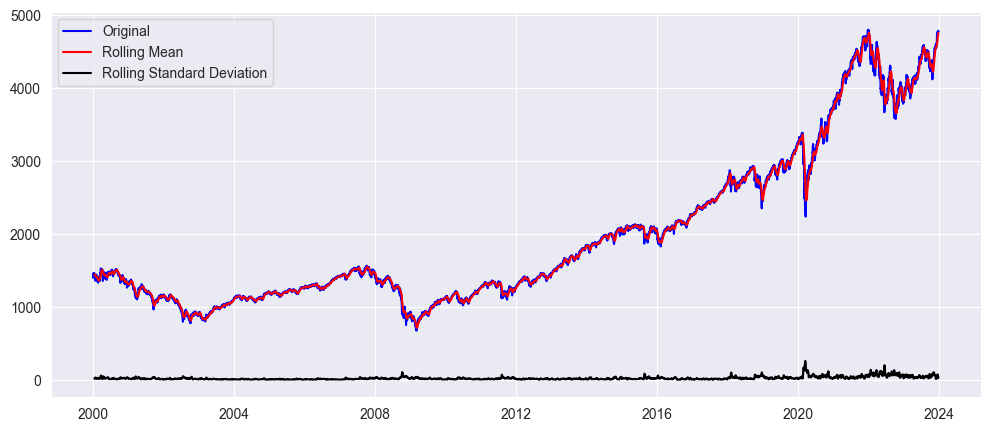

In [336]:
snp_rollmean = snp_data['close'].rolling(12).mean()
snp_rollstd = snp_data['close'].rolling(12).std()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(snp_data['close'], color='b', label='Original')
ax.plot(snp_rollmean, color='r', label='Rolling Mean')
ax.plot(snp_rollstd, color='black', label='Rolling Standard Deviation')
ax.legend()

# Augmented Dicker-Fuller Test
adft = adfuller(snp_data['close'], autolag='AIC')
print('Test Statistic: ', adft[0], adft[4])
# P-value tells us how likely the data would've appeared the way it did if null-hypothesis were true.
print('p-value: ', adft[1])
print('Lags used: ', adft[2])
print('Observations used: ', adft[3])

### Data model synthesis with ARIMA (Autoregressive Integrated Moving Average)

In [428]:
split_date = date_parser.parse(end_date) - relativedelta(years=1)
training_set = snp_data.loc[:split_date]
testing_set = snp_data.loc[split_date:]

diff_training_set = training_set['close'].diff().diff(365).dropna()
# Augmented Dicker-Fuller Test
adft = adfuller(diff_training_set, autolag='AIC')
# P-value tells us how likely the data would've appeared the way it did if null-hypothesis were true.
print('p-value: ', adft[1])

training_exogenous_df = pd.DataFrame({
    'vix': vix_data.loc[:split_date]['close'],
    'ds': training_set.index,
    'unique_id': range(len(training_set['close']))
})
testing_exogenous_df = pd.DataFrame({
    'vix': vix_data.loc[split_date:]['close'],
    'ds': testing_set.index,
    'unique_id': range(len(testing_set['close']))
})
training_df = pd.DataFrame({
    # Note the diff here. We have to make dataset stationary
    'y': training_set['close'],
    'vix': training_exogenous_df['vix'],
    'ds': training_set.index,
    'unique_id': range(len(training_set['close']))
})
testing_df = pd.DataFrame({
    'y': testing_set['close'],
    'vix': testing_exogenous_df['vix'],
    'ds': testing_set.index,
    'unique_id': range(len(testing_set['close']))
})

p-value:  5.2101510214614595e-27


### Select the best PDQ combination

In [381]:
p = [0, 1, 2, 4, 6, 8, 10]
d = range(0, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

models = []

for order in pdq:
    try:
        model = ARIMA(order=order)
        result = model.fit(y=training_df['close'].values)
        aic = result.model_['aic']
        models.append((order, aic))
        print(f'ARIMA{order} - AIC: {aic}')
    except Exception as e:
        print(e)
        raise e

ARIMA(0, 0, 0) - AIC: 99497.19350081251
ARIMA(0, 0, 1) - AIC: 91357.50947476651
ARIMA(0, 0, 2) - AIC: 84698.96322473872
ARIMA(0, 1, 0) - AIC: 55218.983468238584
ARIMA(0, 1, 1) - AIC: 55172.488474612386
ARIMA(0, 1, 2) - AIC: 55168.64579194113
ARIMA(0, 2, 0) - AIC: 59894.7352370183
ARIMA(0, 2, 1) - AIC: 55317.41291899913
ARIMA(0, 2, 2) - AIC: 55275.65341674681
ARIMA(1, 0, 0) - AIC: 55239.58407413643
ARIMA(1, 0, 1) - AIC: 55193.23309933241
ARIMA(1, 0, 2) - AIC: 55189.377853265905
ARIMA(1, 1, 0) - AIC: 55169.73156420067
ARIMA(1, 1, 1) - AIC: 55168.42664685526
ARIMA(1, 1, 2) - AIC: 55169.45533315135
ARIMA(1, 2, 0) - AIC: 57684.19550799592
ARIMA(1, 2, 1) - AIC: 55171.920105686244
ARIMA(1, 2, 2) - AIC: 55175.844960669536
ARIMA(2, 0, 0) - AIC: 55190.47204128519
ARIMA(2, 0, 1) - AIC: 55235.03801772798
ARIMA(2, 0, 2) - AIC: 55176.79718368949
ARIMA(2, 1, 0) - AIC: 55167.76729029528
ARIMA(2, 1, 1) - AIC: 55169.73709275968
ARIMA(2, 1, 2) - AIC: 55226.983468238584
ARIMA(2, 2, 0) - AIC: 57053.1093211

In [410]:
best_order = sorted(models, key=lambda x: x[1])[0][0]
best_order

(10, 1, 0)

In [427]:
# arima_model = StatsForecast(
#     models = [AutoARIMA()],
#     freq=frequency,
#     n_jobs=-1
# )
arima_model = StatsForecast(
    models=[ARIMA(order=best_order)],
    freq=frequency,
    n_jobs=-1
)

# # 5 - AR term. Values will be used to predict the new one.
# # 1 - I term. Difference will be used (current - previous) to make the series stationary
# # 0 - MA term. 0 means do NOT include error differences from the previous values
arima_model = arima_model.fit(df=training_df, target_col='close', time_col='ds')
print(training_df['vix'])
# arima_model = arima_model.fit(df=training_df, target_col='close', time_col='ds')
# print(arima_string(arima_model.fitted_[0,0].model_))

# # Predict next year
steps = len(testing_df['close'])
# snp_synthetic = arima_model.forecast(y=training_df['close'].values, h=steps, level=[90])
# snp_synthetic = arima_model.forecast(h=steps)
# snp_synthetic = arima_model.forecast(df=training_df, h=steps, X_df=testing_exogenous_df, target_col='close', time_col='ds', level=[90])
testing_exogenous_df.shape

ValueError: Not enough data to fit the model

### Cumsum, stationary mean prediction

In [373]:
# snp_synthetic_cumsum = pd.Series([training_df.iloc[-1]['close']], pd.Series(snp_synthetic['mean'])).cumsum()

# last_s = pd.Series([training_set.iloc[-1]['close']])
# mean_s = pd.Series(snp_synthetic['mean'])
# snp_synthetic_cumsum = pd.concat([last_s, mean_s]).reset_index(drop=True).cumsum().drop(0)

# lo_conf_s = pd.concat([last_s, pd.Series(snp_synthetic['lo-90'])]).reset_index(drop=True).cumsum().drop(0)
# hi_conf_s = pd.concat([last_s, pd.Series(snp_synthetic['hi-90'])]).reset_index(drop=True).cumsum().drop(0)

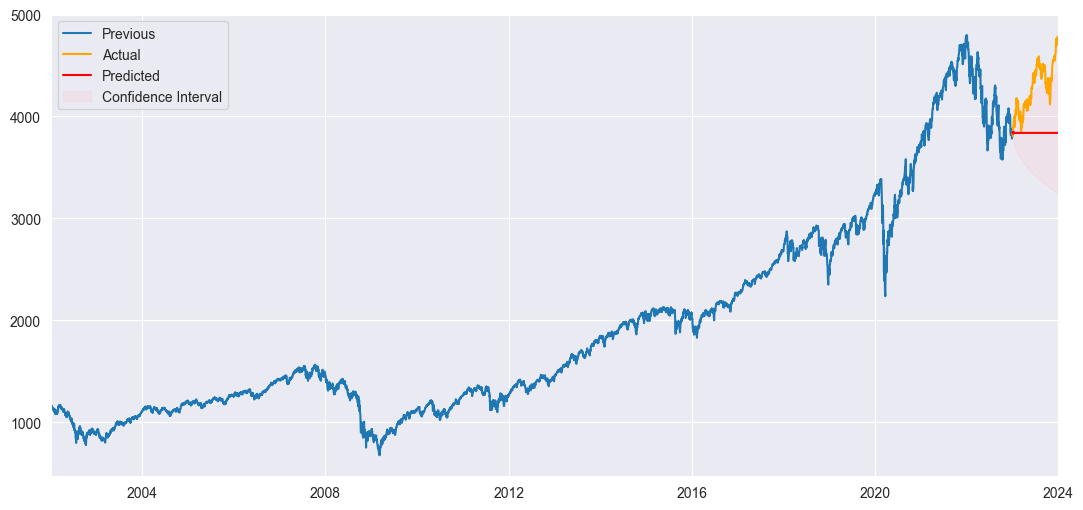

In [379]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.set_xlim(date_parser.parse('2002-01-01'), date_parser.parse('2024-01-01'))
ax.plot(training_set.index, training_set['close'], label='Previous')
ax.plot(testing_set.index, testing_set['close'], color='orange', label='Actual')
# ax.plot(testing_set.index[:steps], snp_synthetic.iloc[len(snp_synthetic['AutoARIMA']) - steps:]['AutoARIMA'], color='r', label='Predicted')
ax.plot(testing_set.index[:steps], snp_synthetic['mean'], color='r', label='Predicted')
# ax.fill_between(testing_set.index[:steps], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.2, label='Confidence Interval')
ax.fill_between(testing_set.index[:steps], snp_synthetic['lo-90'], snp_synthetic['hi-90'], color='pink', alpha=0.2,
                label='Confidence Interval')

ax.legend()

In [87]:
residuals = arima_model.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals)
plt.show()
print(arima_model.summary())

AttributeError: 'StatsForecast' object has no attribute 'resid'

In [281]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate errors
mae = mean_absolute_error(testing_set['close'], snp_synthetic.predicted_mean)
rmse = np.sqrt(mean_squared_error(testing_set['close'], snp_synthetic.predicted_mean))

print("MAE: ", mae)
print("RMSE: ", rmse)

AttributeError: 'dict' object has no attribute 'predicted_mean'